In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
from PIL import Image
from ultralytics import YOLO
from ultralytics import YOLO, solutions

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Load a model
model = YOLO("yolov8n.yaml")
model = YOLO("runs/detect/train/weights/best.pt")

In [3]:
# accepts all formats - image/dir/Path/URL/video/PIL/ndarray. 0 for webcam

#results = model.predict(source="0", show=True)

In [3]:
model.names

{0: '3w', 1: 'bike', 2: 'bus', 3: 'car', 4: 'lorry', 5: 'person', 6: 'van'}

In [ ]:
# Load your YOLO model
model = model

# 0 for webcam, 'filepath' for video files
cap = cv2.VideoCapture("vids/vid1.mp4")
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

out = cv2.VideoWriter("pie_chart.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

analytics = solutions.Analytics(
    type="bar",
    writer=out,
    im0_shape=(w, h),
    view_img=True,
)

# Initialize the cumulative class count dictionary
clswise_count = {}

while cap.isOpened():
    success, frame = cap.read()
    if success:
        results = model.track(frame, persist=True, verbose=True)
        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu()
            clss = results[0].boxes.cls.cpu().tolist()
            for box, cls in zip(boxes, clss):
                class_name = model.names[int(cls)]
                if class_name in clswise_count:
                    clswise_count[class_name] += 1
                else:
                    clswise_count[class_name] = 1

            analytics.update_bar(clswise_count)
        
        # Display the frame with the real-time pie chart (optional)
        results = model.predict(source=frame, show=True)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break



In [ ]:
clswise_count

In [59]:
cap.release()
out.release()
cv2.destroyAllWindows()

Line Counter Initiated.

0: 512x736 2 cars, 800.4ms
Speed: 18.5ms preprocess, 800.4ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 736)

0: 512x736 1 3w, 1 bike, 3 cars, 948.0ms
Speed: 16.7ms preprocess, 948.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 736)

0: 512x736 1 3w, 1 bike, 3 cars, 816.1ms
Speed: 16.0ms preprocess, 816.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 736)

0: 512x736 1 3w, 1 bike, 3 cars, 769.4ms
Speed: 9.2ms preprocess, 769.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 736)

0: 512x736 1 3w, 1 bike, 3 cars, 802.1ms
Speed: 13.1ms preprocess, 802.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 736)

0: 512x736 1 3w, 1 bike, 3 cars, 742.0ms
Speed: 9.0ms preprocess, 742.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 736)

0: 512x736 1 3w, 1 bike, 3 cars, 674.3ms
Speed: 14.0ms preprocess, 674.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 736)

0: 5

KeyboardInterrupt: 

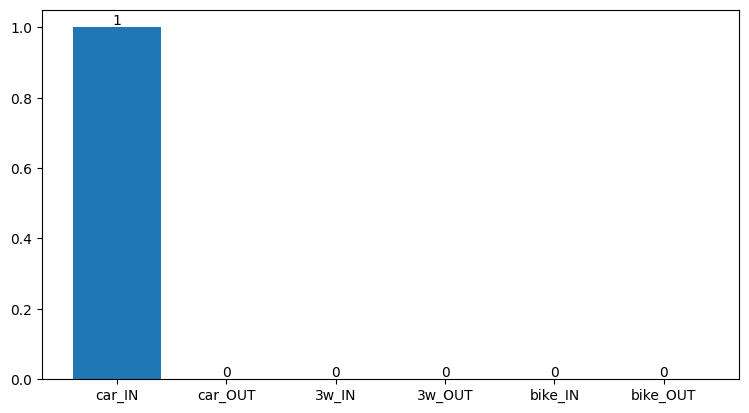

In [58]:


cap = cv2.VideoCapture("vids/vid1.mp4")
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))


# Video writer
video_writer = cv2.VideoWriter("speed_estimation.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
out = cv2.VideoWriter("bar_chart.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps, (900, h))
out2 = cv2.VideoWriter("multiple_line_plot.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

line_pts = [(0, 100), (720, 250)]
line_pts_spd_out = [(0, 100), (340, 170)]
line_pts_spd_in = [(340, 170), (720, 250)]
classes_to_count = [0, 1, 2, 3, 4, 6]

# Init speed-estimation obj
speed_obj = solutions.SpeedEstimator(
    reg_pts=line_pts_spd_out,
    names=model.names,
    view_img=True,
    line_thickness=1,
    region_thickness=2,
    spdl_dist_thresh=20,
)

speed_obj2 = solutions.SpeedEstimator(
    reg_pts=line_pts_spd_in,
    names=model.names,
    view_img=True,
    line_thickness=1,
    region_thickness=2,
    spdl_dist_thresh=20,
)

# Init Object Counter
counter = solutions.ObjectCounter(
    view_img=False,
    reg_pts=line_pts,
    classes_names=model.names,
    draw_tracks=False,
    line_thickness=1,
    track_thickness=1,
    region_thickness=2,
)

analytics = solutions.Analytics(
    type="bar",
    writer=out,
    title = "Classwise Total Vehicle Flow",
    im0_shape=(900, h),
    view_img=True,
)

analytics2 = solutions.Analytics(
    type="line",
    writer=out2,
    line_width=1,
    im0_shape=(w, h),
    view_img=True,
    max_points=200,
    
)

def transform_class_wise_count(counter):
    result = {}
    for vehicle, counts in counter.items():
        for direction, count in counts.items():
            result[f"{vehicle}_{direction}"] = count
    return result

def aggregate_counts(counter):
    result = {'IN': 0, 'OUT': 0}
    for vehicle, counts in counter.items():
        for direction, count in counts.items():
            result[direction] += count
    return result

frame_count = 0
data = {}
labels = ['IN','OUT']

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break
    frame_count += 1
    tracks = model.track(im0, persist=True, show=False, classes=classes_to_count)
    im0 = counter.start_counting(im0, tracks)
    im0 = speed_obj.estimate_speed(im0, tracks)
    im0 = speed_obj2.estimate_speed(im0, tracks)
    if counter.class_wise_count is not None:
        
        analytics.update_bar(transform_class_wise_count(counter.class_wise_count))
        data = aggregate_counts(counter.class_wise_count)
        

    analytics2.update_multiple_lines(data, labels, frame_count)
    #data = {}
    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()

In [83]:
np.max(np.mean(list(speed_obj.dist_data.values())),0)

nan

In [101]:
len(list(speed_obj.dist_data.values()))


0

In [82]:
np.max(np.mean(list(speed_obj2.dist_data.values())),0)

3.1798085945049177

In [85]:
def mean_spead(obj):


    dist_data_values = list(obj.dist_data.values())

    # Check if the list is empty
    if dist_data_values:
        mean_value = np.mean(dist_data_values)
    else:
        mean_value = 0

    return mean_value

In [87]:
mean_spead(speed_obj2)

3.1798085945049177

In [20]:
data['IN']

2

In [15]:
list(transform_class_wise_count(counter.class_wise_count).values())

[1, 0, 1, 0, 0, 0]

In [10]:
list(counter.class_wise_count.keys())

['3w', 'car', 'bike']

In [11]:
list(counter.class_wise_count.values())

[{'IN': 1, 'OUT': 0}, {'IN': 1, 'OUT': 0}, {'IN': 0, 'OUT': 0}]

In [8]:
counter.class_wise_count

{'3w': {'IN': 1, 'OUT': 1},
 'car': {'IN': 1, 'OUT': 0},
 'bike': {'IN': 0, 'OUT': 0}}

In [9]:
data

{}